In [1]:
# !pip install xgboost
# !pip install catboost

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost
import catboost
sns.set_style('darkgrid')
from sklearn import ensemble, preprocessing, model_selection, linear_model, metrics, tree



In [3]:
df = pd.read_csv("data/AirPass.csv").drop("Unnamed: 0", axis=1)
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 103904 non-null  int64  
 1   Gender                             103904 non-null  object 
 2   Customer Type                      103904 non-null  object 
 3   Age                                103904 non-null  int64  
 4   Type of Travel                     103904 non-null  object 
 5   Class                              103904 non-null  object 
 6   Flight Distance                    103904 non-null  int64  
 7   Inflight wifi service              103904 non-null  int64  
 8   Departure/Arrival time convenient  103904 non-null  int64  
 9   Ease of Online booking             103904 non-null  int64  
 10  Gate location                      103904 non-null  int64  
 11  Food and drink                     1039

In [5]:
df.isna().sum().sum()

310

In [6]:
df['Arrival Delay in Minutes'] = \
df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median())
df['Arrival Delay in Minutes'].mean()

15.133392362180475

<Axes: xlabel='satisfaction', ylabel='count'>

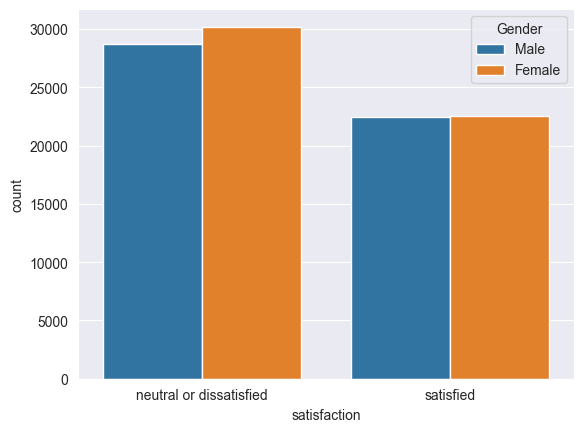

In [7]:
sns.countplot(df, x='satisfaction', hue='Gender')

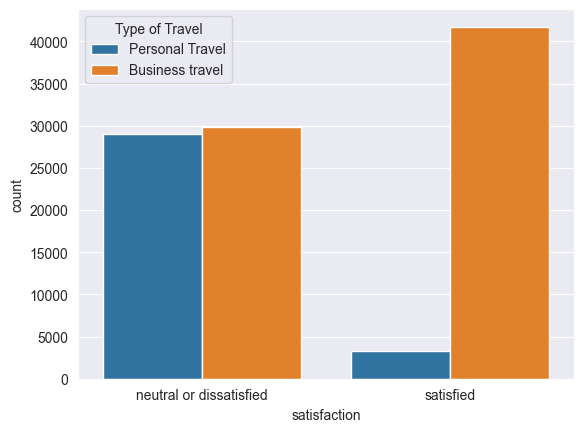

In [8]:
sns.countplot(df, x='satisfaction', hue='Type of Travel');

In [9]:
satisf_by_class = df[df['satisfaction']=='satisfied'].groupby("Class")['id'].count()/ df.groupby("Class")['id'].count()
satisf_by_class.sort_values(ascending=False)

Class
Business    0.694251
Eco Plus    0.246064
Eco         0.186138
Name: id, dtype: float64

In [10]:
df['satisfaction'] = df['satisfaction'].map({'neutral or dissatisfied':0 , 'satisfied':1})
df['Customer Type'] = df['Customer Type'].map({'Loyal Customer':1, 'disloyal Customer':0})
df['Type of Travel'] = df['Type of Travel'].map({'Personal Travel':0, 'Business travel':1})
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

In [11]:
df_dummy = pd.get_dummies(df)
df_dummy 

,id,Gender,Customer Type,Age,Type of Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Class_Business,Class_Eco,Class_Eco Plus
0,70172,0,1,13,0,460,3,4,3,1,...,4,4,5,5,25,18.0,0,False,False,True
1,5047,0,0,25,1,235,3,2,3,3,...,3,1,4,1,1,6.0,0,True,False,False
2,110028,1,1,26,1,1142,2,2,2,2,...,4,4,4,5,0,0.0,1,True,False,False
3,24026,1,1,25,1,562,2,5,5,5,...,3,1,4,2,11,9.0,0,True,False,False
4,119299,0,1,61,1,214,3,3,3,3,...,4,3,3,3,0,0.0,1,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,94171,1,0,23,1,192,2,1,2,3,...,4,2,3,2,3,0.0,0,False,True,False
103900,73097,0,1,49,1,2347,4,4,4,4,...,5,5,5,4,0,0.0,1,True,False,False
103901,68825,0,0,30,1,1995,1,1,1,3,...,4,5,5,4,7,14.0,0,True,False,False
103902,54173,1,0,22,1,1000,1,1,1,5,...,1,5,4,1,0,0.0,0,False,True,False


In [12]:
X = df_dummy.drop('satisfaction', axis=1)
y = df_dummy['satisfaction']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, random_state=26, test_size=0.2)
X_test.shape


(20781, 25)

In [13]:
ss_scaler = preprocessing.StandardScaler()
X_train_scaled = ss_scaler.fit_transform(X_train)
X_test_scaled = ss_scaler.transform(X_test)

In [14]:
lr = linear_model.LogisticRegression()
lr.fit(X_train_scaled, y_train)
preds = lr.predict(X_test_scaled)
print(f"Lr f1: {metrics.f1_score(y_test, preds)}")


Lr f1: 0.8546883773161146


In [15]:
ada_boost = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(), random_state=26)
ada_boost.fit(X_train_scaled, y_train)
preds = ada_boost.predict(X_test_scaled)
print(f"Ada f1: {metrics.f1_score(y_test, preds)}")

Ada f1: 0.9404794558121674


In [18]:
params = {"n_estimators":2**np.arange(8), "learning_rate":0.1**np.arange(3)}
gbm = model_selection.GridSearchCV(ensemble.GradientBoostingClassifier(random_state=26),
                                   param_grid=params,
                                   cv=2,
                                   verbose=2)
gbm.fit(X_train_scaled,y_train)
preds = gbm.best_estimator_.predict(X_test_scaled)
print(f"gbm f1: {metrics.f1_score(y_test, preds)}")

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] END ..................learning_rate=1.0, n_estimators=1; total time=   0.0s
[CV] END ..................learning_rate=1.0, n_estimators=1; total time=   0.0s
[CV] END ..................learning_rate=1.0, n_estimators=2; total time=   0.1s
[CV] END ..................learning_rate=1.0, n_estimators=2; total time=   0.1s
[CV] END ..................learning_rate=1.0, n_estimators=4; total time=   0.3s
[CV] END ..................learning_rate=1.0, n_estimators=4; total time=   0.3s
[CV] END ..................learning_rate=1.0, n_estimators=8; total time=   0.7s
[CV] END ..................learning_rate=1.0, n_estimators=8; total time=   0.7s
[CV] END .................learning_rate=1.0, n_estimators=16; total time=   1.5s
[CV] END .................learning_rate=1.0, n_estimators=16; total time=   1.5s
[CV] END .................learning_rate=1.0, n_estimators=32; total time=   3.1s
[CV] END .................learning_rate=1.0, n_e

In [17]:
gbm.best_score_

0.94911096494409

In [32]:
xgb = xgboost.XGBClassifier(random_state=26)
xgb.fit(X_train,y_train)
preds = xgb.predict(X_test)
print(f"gbm f1: {metrics.f1_score(y_test, preds)}")

Xgboost f1: 0.9752680003376382


In [50]:
import tensorboard
cb = catboost.CatBoostClassifier(random_state=26, verbose=1)
cb.fit(X_train, y_train)
preds = cb.predict(X_test)
print(f"catboost f1: {metrics.f1_score(y_test, preds)}")


Learning rate set to 0.068023
0:	learn: 0.6018138	total: 11.9ms	remaining: 11.8s
1:	learn: 0.5020760	total: 23.9ms	remaining: 11.9s
2:	learn: 0.4472472	total: 35.3ms	remaining: 11.7s
3:	learn: 0.4028682	total: 47.7ms	remaining: 11.9s
4:	learn: 0.3674730	total: 59ms	remaining: 11.8s
5:	learn: 0.3397846	total: 70.7ms	remaining: 11.7s
6:	learn: 0.3121210	total: 83.3ms	remaining: 11.8s
7:	learn: 0.2917499	total: 96.2ms	remaining: 11.9s
8:	learn: 0.2749040	total: 111ms	remaining: 12.2s
9:	learn: 0.2575190	total: 124ms	remaining: 12.3s
10:	learn: 0.2473691	total: 135ms	remaining: 12.1s
11:	learn: 0.2377531	total: 146ms	remaining: 12.1s
12:	learn: 0.2279311	total: 159ms	remaining: 12.1s
13:	learn: 0.2212512	total: 171ms	remaining: 12s
14:	learn: 0.2100358	total: 181ms	remaining: 11.9s
15:	learn: 0.2025732	total: 193ms	remaining: 11.9s
16:	learn: 0.1942301	total: 205ms	remaining: 11.8s
17:	learn: 0.1877938	total: 220ms	remaining: 12s
18:	learn: 0.1832380	total: 235ms	remaining: 12.1s
19:	learn

In [29]:
cb.best_score_

{'learn': {'Logloss': 0.056759996942550135}}

In [40]:
from catboost.utils import get_confusion_matrix
from catboost import Pool
cm = get_confusion_matrix(cb, Pool(X_train, y_train))
print(f"Confusion matrix {np.round(cm/X_train.shape[0]*100)}")


[[56.  1.]
 [ 2. 42.]]


In [37]:
cm = metrics.confusion_matrix(y_train, cb.predict(X_train))
print(cm)

[[46665   541]
 [ 1256 34661]]


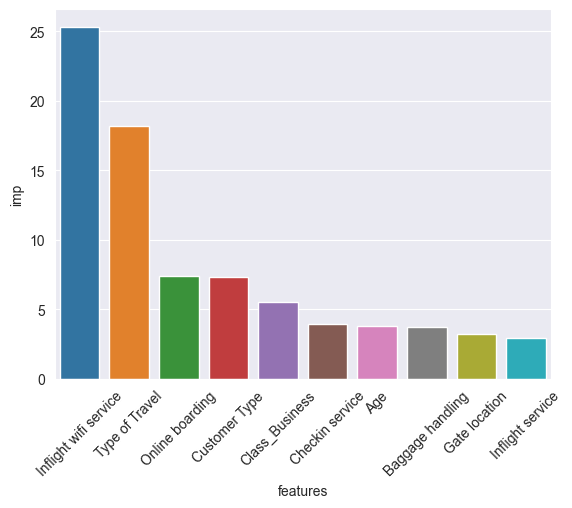

In [49]:
importans = pd.DataFrame({'features': cb.feature_names_, 'imp': cb.feature_importances_}).sort_values(by='imp', ascending=False)
sns.barplot(importans.iloc[:10,:], x='features', y='imp').xaxis.set_tick_params(rotation=45)